<div class="alert alert-block alert-info">
    
<center> 
    
# __Lead-Lag Portfolios__ 
### __Hermitian Clustering of Directed Networks__ 
    
</center>

</div>

In [1]:
import sys
sys.path.append('../src')

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import yfinance as yf

from levy import Levy
from hermitian import Hermitian

## __1. Introduction__

Graph clustering is a basic technique in machine learning, and has widespread applications in different domains. **While spectral techniques have been successfully applied for clustering undirected graphs, the performance of spectral clustering algorithms for directed graphs (digraphs) is not in general satisfactory.** When the underlying graph to cluster is undirected, the objective is to partition the vertices of the graph into clusters such that vertices within the same cluster are on average better connected to one another than vertices belonging to different clusters. These algorithms usually require symmetrising the matrix representing a digraph, and typical objective functions for undirected graph clustering do not capture cluster-structures in which the information given by the direction of the edges is crucial.  

To overcome these downsides, **Hermitian clustering** which is a spectral clustering algorithm based on a complex-valued matrix representation of digraphs, is proposed in [Hermitian Matrices for Clustering Directed Graphs: Insights and Applications](https://arxiv.org/abs/1908.02096) paper. In this clustering algorithm, the cluster-structure is given not only by variations in edge densities, but also by the direction of the edges.

## __2. From Lead-Lag Scoring Matrix, $S$ to Lead-Lag Directed Network__

Once, we have the lead-lag scoring matrxi, $S$, we can create a directed netwrok from it. Let $S_{ij}$ denote the user-defned lead–lag metric that quantifes how much time series variable $i$ leads $j$. The value $S_{ij}$ can be positive or negative, and satisfes $S_{ij} = −S_{ij}$. The lead-lag relationships between all pairs of time series is encoded by the asymmetric matrix $A$:
$$
A_{ij} = max(S_{ij}, 0)
$$ 

Using $A$, we can create the directed network $G$:

In [2]:
# ticker of price panel
tickers = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRT-USD', 'SOL-USD',
           'ADA-USD', 'DOGE-USD', 'TRX-USD', 'MATIC-USD', 'DOT-USD']

# Download historical data and filter-out Adj Close, remove "-USD" from ticker symbols
price_panel = yf.download(tickers, start='2023-09-01', end='2023-11-01')
price_panel = price_panel['Adj Close']
price_panel.columns = price_panel.columns.str.replace('-USD', '')

levy_leadlag = Levy(price_panel=price_panel)
s_matrix = levy_leadlag.generate_levy_matrix()
s_matrix.style.format("{:.3}")
s_matrix

[*********************100%%**********************]  10 of 10 completed


,ADA,BNB,BTC,DOGE,DOT,ETH,MATIC,SOL,TRX,XRT
ADA,0.000000,0.309219,7.681769,-1.078782,1.513666,2.199245,-0.770972,1.745152,-3.821588,6.489668
BNB,-0.309219,0.000000,12.609583,0.797457,-0.202014,5.160752,-1.872406,2.390579,-1.153304,11.539849
BTC,-7.681769,-12.609583,0.000000,-0.238440,-5.430294,-4.994685,-7.330066,0.394093,-4.823718,2.367451
DOGE,1.078782,-0.797457,0.238440,0.000000,-2.813624,0.821426,-5.856672,-2.028225,-2.549153,6.948537
DOT,-1.513666,0.202014,5.430294,2.813624,0.000000,1.565993,-4.806967,1.313334,-4.893720,6.850261
ETH,-2.199245,-5.160752,4.994685,-0.821426,-1.565993,0.000000,-3.179912,0.405066,-6.140925,4.619787
MATIC,0.770972,1.872406,7.330066,5.856672,4.806967,3.179912,0.000000,-0.012444,-7.703481,6.086996
SOL,-1.745152,-2.390579,-0.394093,2.028225,-1.313334,-0.405066,0.012444,0.000000,-6.095021,0.700857
TRX,3.821588,1.153304,4.823718,2.549153,4.893720,6.140925,7.703481,6.095021,0.000000,6.393440
XRT,-6.489668,-11.539849,-2.367451,-6.948537,-6.850261,-4.619787,-6.086996,-0.700857,-6.393440,0.000000


In [3]:
# Calculate adjacency matrix, A using matrix S
a_matrix = np.maximum(s_matrix, 0)

# Create a directed graph from the adjacency matrix in the DataFrame
G = nx.from_pandas_adjacency(a_matrix, create_using=nx.DiGraph)

Now, we can plot the directed network:

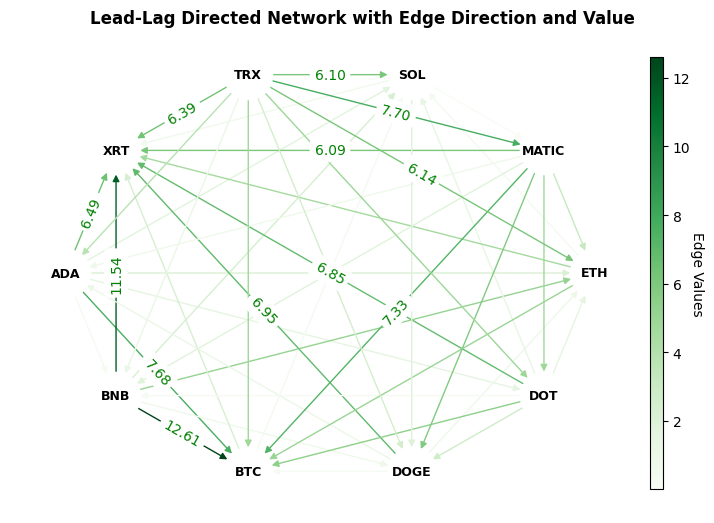

In [4]:
# Extract edge values
edge_values = nx.get_edge_attributes(G, 'weight').values()

# Create a color map from edge values
edge_cmap = plt.cm.Greens  
edge_norm = plt.Normalize(min(edge_values), max(edge_values))

# Draw the graph
pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True, 
        font_weight='bold', 
        font_color='black', 
        font_size=9, 
        node_size=1200, 
        node_color='white',
        edge_color=edge_values, edge_cmap=edge_cmap, 
        edge_vmin=min(edge_values), edge_vmax=max(edge_values), 
        width=1, arrowsize=10)

# Draw edge labels for edges with values greater than 6
edge_labels = {(i, j): f'{G[i][j]["weight"]:.2f}' for i, j in G.edges() if G[i][j]["weight"] > 6}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='green')


# Add color bar with explicit Axes
fig = plt.gcf()
cax = fig.add_axes([1, 0.05, 0.02, 0.9])  
sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=edge_norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label('Edge Values', rotation=270, labelpad=10)

# Add title
plt.suptitle('Lead-Lag Directed Network with Edge Direction and Value', fontweight='bold', y=1.05, x=0.55)

# Show the plot
plt.show()

## __2. Hermitian Clustering of Directed Network__

The Hermitian clustering procedure for clustering directed networks considers the spectrum of the complex matrix $\widetilde{A} \in \mathbb{C}^{p \times p}$, which is derived from the directed network adjacency matrix as:
$$
\widetilde{A} = i(A-A^{T}), \ i = \sqrt{-1}
$$
$\widetilde{A}$ is the adjacency Hermitian matrix of the directed network $G$. Since $\widetilde{A}$ is Hermitian, it has $p$ real valued eigenvalues which we order by magnitude $|\lambda_1| \geq \ldots \geq |\lambda_p|$. The eigenvector associated with $\lambda_j$ is denoted by $g_j ∈ ℂ_p$ where, in Euclidean norm, $\| g_j \| = 1 $ for $1 ≤ j ≤ p$. Algorithm 1 describes the procedure for clustering the directed network $G$. In our implementation, we set the number of top eigenvectors to $l = k$ for even values of $k$ and $l = k - 1$ for odd values of $k$.

<center>
  <img src="../images/hermitian.png" style="width:700px;"/>
</center>

Note that in practice, for scalability purposes, one can bypass the computation of the entire $n×n$ matrix $P$ in order to directly cluster using the embedding given by the top $l$ eigenvectors.

[Cucuringu et al. (2020)](https://arxiv.org/abs/1908.02096) study the performance of the algorithm theoretically and experimentally under data generated from a directed version of a stochastic block model that embeds latent structure in terms of fow imbalance between clusters. They show that the algorithm is __able to discover cluster structures based on directed edge imbalance__. This contrasts with previous spectral clustering methods that detect clusters based purely on the edge-density of symmetrised networks. The Hermitian clustering algorithm is particularly suited to our setting of clustering lead–lag networks, since we aim to extract pairs of clusters with high flow imbalance. In addition, as a pre-processing step for this algorithm, we apply random-walk normalisation to the adjacency matrix $\widetilde{A}$, so that the method is robust to heterogeneous degree distributions; we refer to the resulting algorithm as the __Hermitian RW__ algorithm.

## __3. Hermitian-RW Python Implementation__

The Hermitian clustering algorithm is implemented in `hermitian.py`, and we use it to cluster our sample directed network, $G$, built upon the Levy scoring matrix, denoted as $S$. Now, we can do clustering with $k=2$ for our directed netwrork and identify the assets that fall into each cluster.

In [5]:
# Do clustering and show clusters data
clusterer = Hermitian(directed_net = G)    
clusters = clusterer.cluster_hermitian_opt(k_min=2, k_max=2)
clusters

{1: ['ADA', 'BNB', 'DOT', 'MATIC', 'TRX'],
 0: ['BTC', 'DOGE', 'ETH', 'SOL', 'XRT']}

Now, let's plot the directed networks and highlight the clusters:

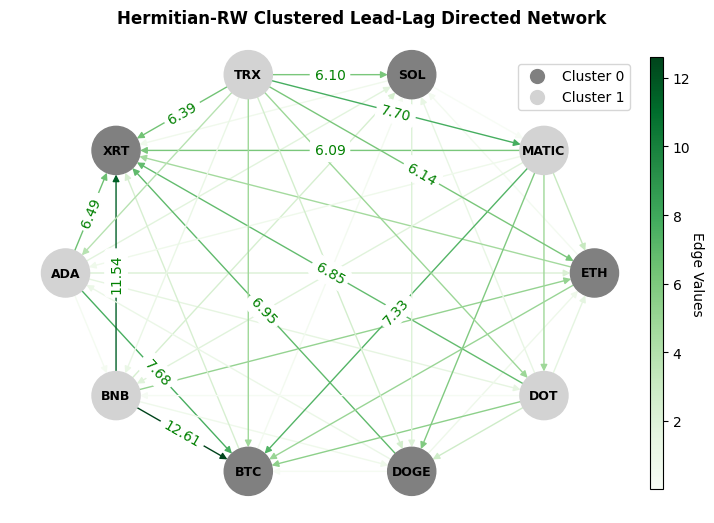

In [6]:
# Create a color map for clusters
cluster_colors = {0: 'gray', 1: 'lightgray'}

# Assign colors to nodes based on their cluster
node_colors = {node: cluster_colors[cluster] for cluster, nodes in clusters.items() for node in nodes}

# Draw the graph with node colors
pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True,
        font_weight='bold',
        font_color='black',
        font_size=9,
        node_size=1200,
        node_color=[node_colors[node] for node in G.nodes()],
        edge_color=edge_values, edge_cmap=edge_cmap,
        edge_vmin=min(edge_values), edge_vmax=max(edge_values),
        width=1, arrowsize=10)

# Draw edge labels for edges with values greater than 6
edge_labels = {(i, j): f'{G[i][j]["weight"]:.2f}' for i, j in G.edges() if G[i][j]["weight"] > 6}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='green')

# Add color bar with explicit Axes
fig = plt.gcf()
cax = fig.add_axes([1, 0.05, 0.02, 0.9])
sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=edge_norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label('Edge Values', rotation=270, labelpad=10)

# Add legend for cluster colors with adjusted position
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}', markerfacecolor=color, markersize=12) for cluster, color in cluster_colors.items()]
plt.legend(handles=legend_labels, loc='upper right', bbox_to_anchor=(-1, 1))  # Adjust the values as needed

# Add title
plt.suptitle('Hermitian-RW Clustered Lead-Lag Directed Network', fontweight='bold', y=1.05, x=0.55)

# Show the plot
plt.show()

The **Hermitian RW** method targets clusters with high flow imbalance and is therefore particularly suited to clustering time series based on directed imbalances in their lead–lag relations. In this example, you can see that the nodes in Cluster 0 have a good inflow, whereas the nodes in Cluster 1 have outflow. So, it is obvious that there is a high flow imbalance between the two clusters.

In a directed network, flow imbalance refers to the asymmetry in the distribution of influence or interactions between nodes. It measures how much the incoming and outgoing edges of a node differ in terms of their weights or strengths. This concept is particularly relevant in the context of lead-lag relationships or directional influence between nodes. In financial networks or systems, flow imbalance could signify a directional bias in the interactions between different assets or variables. For example, in a lead-lag network, a high flow imbalance from Cluster 1 to Cluster 0 suggests that Cluster 1 tends to lead Cluster 0 more strongly than the reverse. It provides a quantitative measure of the directional strength of relationships between nodes. Understanding flow imbalance is crucial for uncovering patterns of influence, identifying leaders and followers, and gaining insights into the dynamics of directed networks, especially in scenarios where the directionality of relationships plays a significant role.